# Markowitz Portfolio's Theory #

### Building the Efficient Frontier ###

In [2]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Optimization
from scipy.optimize import minimize

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from config import get_tickers
from data_downloader import get_market_data

In [3]:
tickers = get_tickers(mod="2.2")

tickers

['AAPL', 'AMZN', 'JPM', 'JNJ', 'XOM']

In [4]:
# Import data
df_returns = pd.DataFrame()

for ticker in tickers:
    df = get_market_data(
        ticker=ticker, 
        start_date='2015-01-01', 
        end_date='2025-01-01', 
        returns=True
    )
    
    returns = df['returns'].rename(ticker)
    
    df_returns = pd.concat([df_returns, returns], axis=1)
    
    print(f'Data Ready for {ticker}')


Data Ready for AAPL
Data Ready for AMZN
Data Ready for JPM
Data Ready for JNJ
Data Ready for XOM


In [5]:
df_returns

,AAPL,AMZN,JPM,JNJ,XOM
2015-01-05 00:00:00,-0.028576,-0.020731,-0.031537,-0.007009,-0.027743
2015-01-06 00:00:00,0.000094,-0.023098,-0.026271,-0.004925,-0.005331
2015-01-07 00:00:00,0.013925,0.010544,0.001525,0.021835,0.010082
2015-01-08 00:00:00,0.037702,0.006813,0.022100,0.007832,0.016508
2015-01-09 00:00:00,0.001072,-0.011818,-0.017540,-0.013723,-0.001411
...,...,...,...,...,...
2024-12-24 00:00:00,0.011413,0.017573,0.016310,0.003985,0.000940
2024-12-26 00:00:00,0.003171,-0.008770,0.003420,-0.001853,0.000845
2024-12-27 00:00:00,-0.013331,-0.014641,-0.008135,-0.003647,-0.000094
2024-12-30 00:00:00,-0.013352,-0.011010,-0.007700,-0.011859,-0.006785


In [6]:
# Theoretically, we could use the average as the expected returns (these are daily returns)
expected_returns = df_returns.mean()
expected_returns.name = 'mean_returns'

expected_returns

AAPL    0.000927
AMZN    0.001056
JPM     0.000642
JNJ     0.000239
XOM     0.000232
Name: mean_returns, dtype: float64

In [7]:
# The volatility is calculated with the standard deviations (also daily volatilities)
volatility = df_returns.dropna().std()
volatility.name = 'volatility'

volatility

AAPL    0.017931
AMZN    0.020573
JPM     0.017210
JNJ     0.011386
XOM     0.017508
Name: volatility, dtype: float64

In [8]:
# Covariance Matrix
cov_matrix = df_returns.dropna().cov()

cov_matrix

,AAPL,AMZN,JPM,JNJ,XOM
AAPL,0.000322,0.000205,0.000129,0.000070,0.000097
AMZN,0.000205,0.000423,0.000106,0.000052,0.000066
JPM,0.000129,0.000106,0.000296,0.000078,0.000168
JNJ,0.000070,0.000052,0.000078,0.000130,0.000064
XOM,0.000097,0.000066,0.000168,0.000064,0.000307


In [17]:
# Correlation Matrix
corr_matrix = df_returns.corr()

corr_matrix

,AAPL,AMZN,JPM,JNJ,XOM
AAPL,1.000000,0.556771,0.418988,0.344631,0.307402
AMZN,0.556771,1.000000,0.297973,0.220708,0.182160
JPM,0.418988,0.297973,1.000000,0.399083,0.558844
JNJ,0.344631,0.220708,0.399083,1.000000,0.323389
XOM,0.307402,0.182160,0.558844,0.323389,1.000000


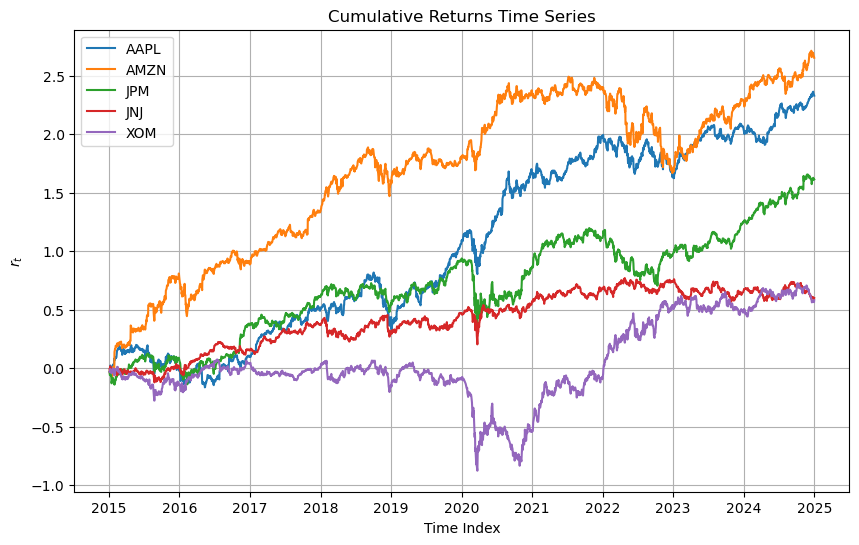

In [18]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns.cumsum(), label=df_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('$r_t$')
plt.legend()

# Show
plt.grid(True)
plt.show()

The Markowitz's Theory establishes that a portfolio's returns and variance are defined by the following equations:

Portfolio Returns: $ \mu_P = \sum_{i=1}^{n}{\omega_i\mu_i} $

Portfolio Variance: $ \sigma_P^2 = \sum_{i=1}^{n}\sum_{j=1}^{n}\omega_i\omega_j\gamma_{ij}$

In [19]:
# To create random portfolios, first we need to create random weights:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [20]:
# An example
rand_weights(5)

array([0.14223113, 0.30218438, 0.22069205, 0.06550145, 0.26939099])

In [21]:
### This function create a random portfolio based on random weights
def random_portfolio(
        expected_returns, 
        cov_matrix
):
    # Generate Random Weights
    weights = rand_weights(len(expected_returns))
    
    # Calculate the Portfolio's Returns
    portfolio_returns = np.dot(weights, expected_returns)
    
    # Calculate the Portfolio's Risk
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_stddev = np.sqrt(portfolio_variance)
    
    return portfolio_returns, portfolio_stddev

In [22]:
# Calculate a portfolio
returns_i, risk_i = random_portfolio(expected_returns, cov_matrix)

print(f"The Random Portfolio's Return is: {returns_i.round(3)}")
print(f"The Random Portfolio's Volatility is: {risk_i.round(3)}")

The Random Portfolio's Return is: 0.001
The Random Portfolio's Volatility is: 0.012


In [23]:
# We can use this function to generate several random portfolios
def generate_random_portfolios(
        n_portfolios, 
        expected_returns, 
        cov_matrix
):

    # Lists to store the portfolios' information
    means = []
    stds = []

    # Generate the portfolios
    for _ in range(n_portfolios):
        mean, std = random_portfolio(expected_returns.values.flatten(), cov_matrix)
        means.append(mean)
        stds.append(std)
    
    # Store them in a DataFrame
    portfolios = pd.DataFrame({
        'Mean Return': means,
        'Std Dev': stds
    })
    
    return portfolios

In [24]:
n_portfolios = 1000
portfolios = generate_random_portfolios(n_portfolios, expected_returns, cov_matrix)

portfolios

,Mean Return,Std Dev
0,0.000545,0.011127
1,0.000541,0.012774
2,0.000604,0.013275
3,0.000589,0.011504
4,0.000587,0.011975
...,...,...
995,0.000702,0.012405
996,0.000472,0.010876
997,0.000559,0.011935
998,0.000550,0.011140


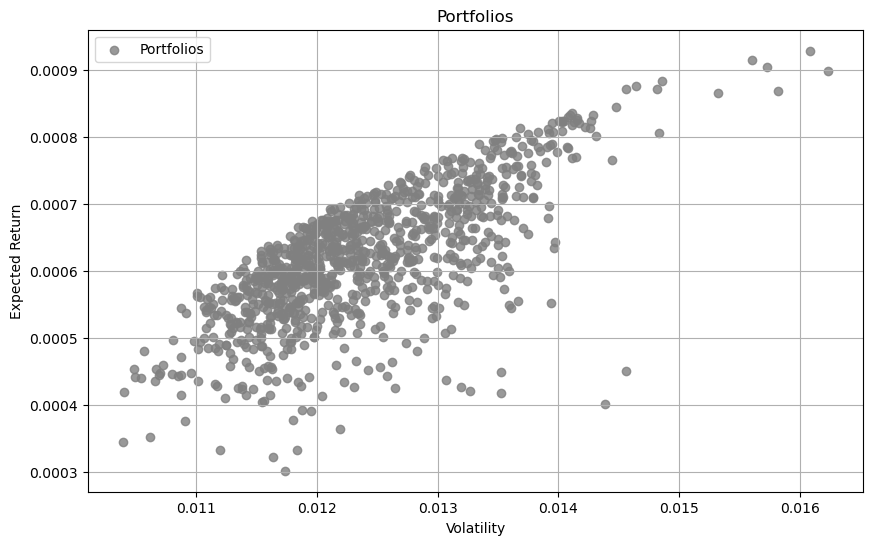

In [25]:
# Portfolios Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='gray', alpha=0.8, label='Portfolios')

# Config
plt.title('Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [26]:
# We can create the Equal-Weighted Portfolio to compare it with the other portfolios
def equal_weighted_portfolio(
        expected_returns, 
        cov_matrix
):
    # Generate the Equal Weights
    n = len(expected_returns)
    weights = np.ones(n) / n  

    # Calculate the Portfolio's Returns
    portfolio_return = np.dot(weights, expected_returns)
    
    # Calculate the Portfolio's Risk
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return portfolio_return, portfolio_volatility

In [27]:
# Calculate the EWP
returns_e, risk_e = equal_weighted_portfolio(expected_returns, cov_matrix)

print(f"The Equal-Weighted Portfolio's Return is: {returns_e.round(3)}")
print(f"The Equal-Weighted Portfolio's Volatility is: {risk_e.round(3)}")

The Equal-Weighted Portfolio's Return is: 0.001
The Equal-Weighted Portfolio's Volatility is: 0.012


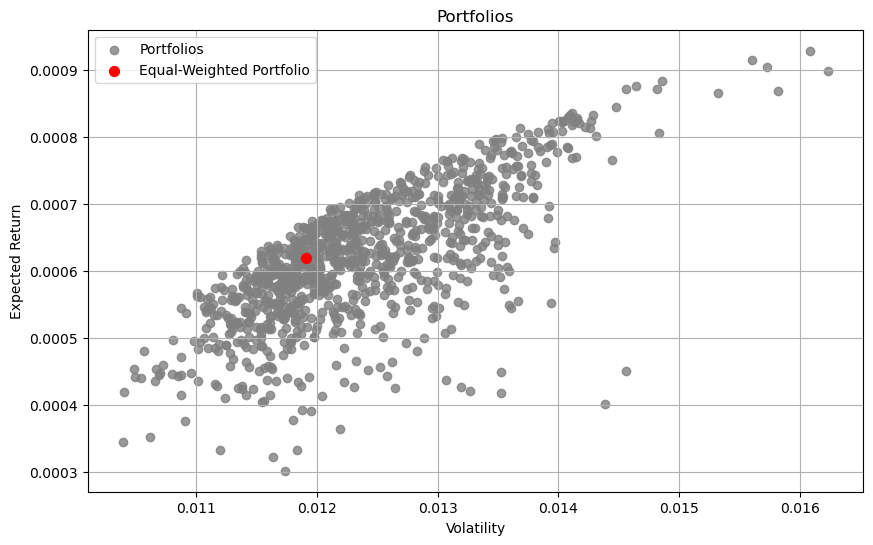

In [28]:
# Portfolios Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='gray', alpha=0.8, label='Portfolios')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio')  


# Config
plt.title('Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [29]:
# Now how can we get the Efficient Frontier?

# Optimization functions
def portfolio_performance(
        weights, 
        expected_returns, 
        cov_matrix
):
    # Portfolio's Returns
    portfolio_return = np.dot(weights, expected_returns)

    #Portfolio's Volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return portfolio_return, portfolio_volatility
    
# Minimizing Portfolio
def minimize_volatility(
        weights, 
        expected_returns, 
        cov_matrix
):
    return portfolio_performance(weights, expected_returns, cov_matrix)[1]

# Function that generates the portfolios that are located in the Efficient Frontier
def get_efficient_frontier(
        expected_returns, 
        cov_matrix, 
        num_portfolios=100
):
    results = np.zeros((2, num_portfolios))
    target_returns = np.linspace(expected_returns.min(), expected_returns.max(), num_portfolios)
    
    for i, target in enumerate(target_returns):
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},                          # weights must sum one
                       {'type': 'eq', 'fun': lambda x: np.dot(x, expected_returns) - target})   # portfolio returns
        bounds = tuple((-1, 1) for _ in range(len(expected_returns)))                           # no short if bounds [0,1]
        initial_guess = len(expected_returns) * [1. / len(expected_returns)]
        
        opt = minimize(minimize_volatility, initial_guess, args=(expected_returns, cov_matrix),
                       method='SLSQP', bounds=bounds, constraints=constraints)
        
        if opt.success:
            results[0, i] = target
            results[1, i] = opt.fun

    return results

In [30]:
# Calculate the EF
efficient_frontier = get_efficient_frontier(expected_returns, cov_matrix)

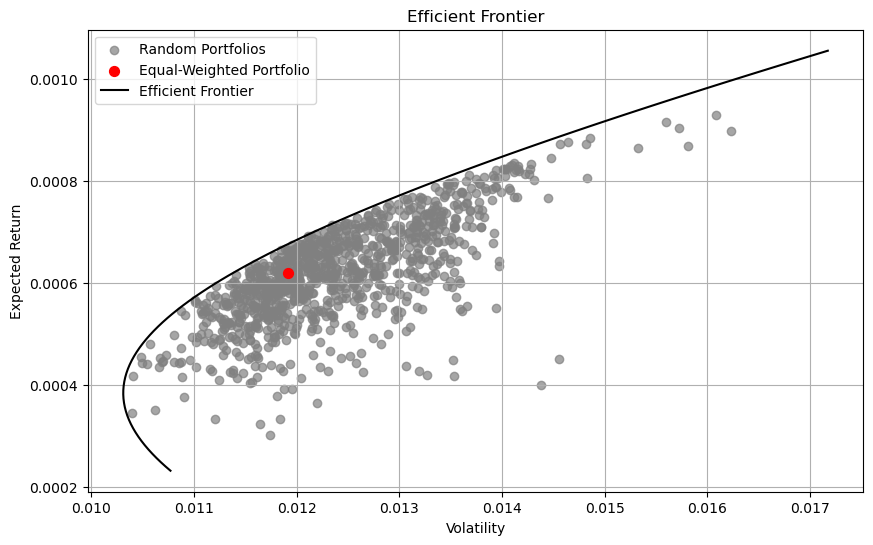

In [31]:
# Portfolios Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='gray', alpha=0.7, label='Random Portfolios')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio')  
plt.plot(efficient_frontier[1, :], efficient_frontier[0, :], label='Efficient Frontier', color='black')


# Config
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()

The equation of the Efficient Frontier will have the next form:

1) $ \sigma_P^2 = \pi_0 - \pi_1\mu_P + \pi_2\mu_P^2 $

The coefficients of the equation will have the next form:

1) $ \pi_0 = \frac{A}{D} $
2) $ \pi_1 = \frac{2B}{D} $
3) $ \pi_2 = \frac{C}{D} $

The next equations define the components of the coefficients:

1) $ A = \mu^⊤\Sigma^{-1}\mu $
2) $ B = \mu^⊤\Sigma^{-1}\iota $
3) $ C = \iota^⊤\Sigma^{-1}\iota" $
4) $ D = AC-B^2 $


In [32]:
# So let us get the components
n = len(expected_returns)                                   # Number of Stocks
mu = expected_returns.values.flatten().reshape(-1, 1)       # Expected Returns
Sigma = cov_matrix.values                                   # Covariance Matrix
Sigma_inv = np.linalg.inv(Sigma)                            # Inverse Covariance Matrix
iota = np.ones((n, 1))                                      # Vector of Ones

In [33]:
# And now obtain the coefficients of the Efficient Frontier

A = np.dot(np.dot(mu.T, Sigma_inv), mu)
B = np.dot(np.dot(iota.T, Sigma_inv), mu)
C = np.dot(np.dot(iota.T, Sigma_inv), iota)
D = (A*C - B*B)

print(f"This is A: {A[0][0]}")
print(f"This is B: {B[0][0]}")
print(f"This is C: {C[0][0]}")
print(f"This is D: {D[0][0]}")

This is A: 0.0037809602492164824
This is B: 3.62385222041548
This is C: 9434.282149611361
This is D: 22.538340872162983


In [34]:
# Then the equation
pi_0 = A/D
pi_1 = 2*B/D
pi_2 = C/D

print(f"This is the first coefficient: {pi_0[0][0]}")
print(f"This is the second coefficient: {pi_1[0][0]}")
print(f"This is the third coefficient: {pi_2[0][0]}")

This is the first coefficient: 0.0001677568136298059
This is the second coefficient: 0.3215722258324068
This is the third coefficient: 418.5881384580356


In [37]:
# Now let us get the values of the efficient frontier
def eff_equation(mu_P):
    return np.sqrt((pi_0 - pi_1 * mu_P + pi_2 * mu_P**2))

# Create a rango of values for mu_P
mu_P_values = np.linspace(0.00025, 0.001, 400)

# Evaluate the equation for mu_P values
sigma_P_values = eff_equation(mu_P_values).reshape(-1, 1)

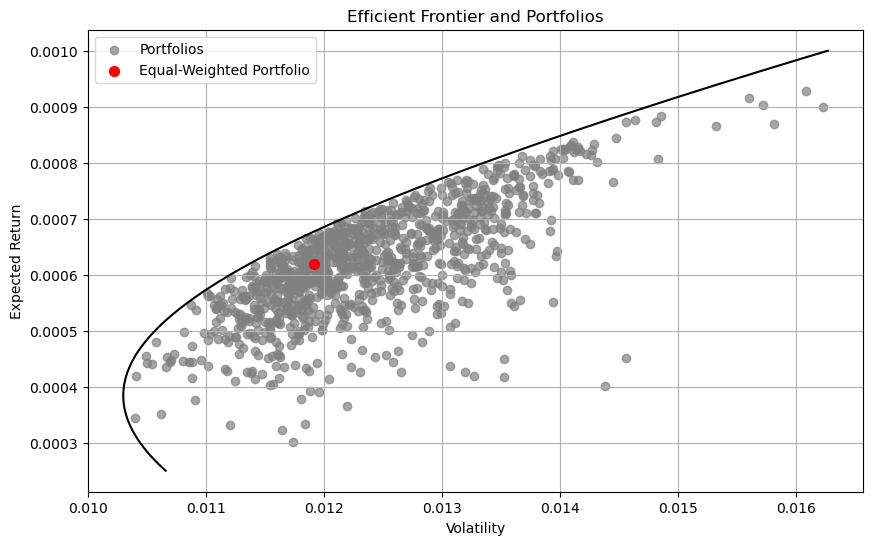

In [38]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='grey', alpha=0.7, label='Portfolios')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio') 
plt.plot(sigma_P_values, mu_P_values, color='black')


# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()


In [39]:
# Let us check if this equation is indeed correct; for the equal-weighted portfolio's volatility
risk_e_optimal = eff_equation(returns_e)[0][0]

print(f"The Equal-Weighted Portfolio's Returns: {returns_e}")
print(f"The Equal-Weighted Portfolio's Volatility: {risk_e}")
print(f"The Optimal Volatility: {risk_e_optimal}")

The Equal-Weighted Portfolio's Returns: 0.0006189763821298838
The Equal-Weighted Portfolio's Volatility: 0.011913061401428098
The Optimal Volatility: 0.011361584906050026


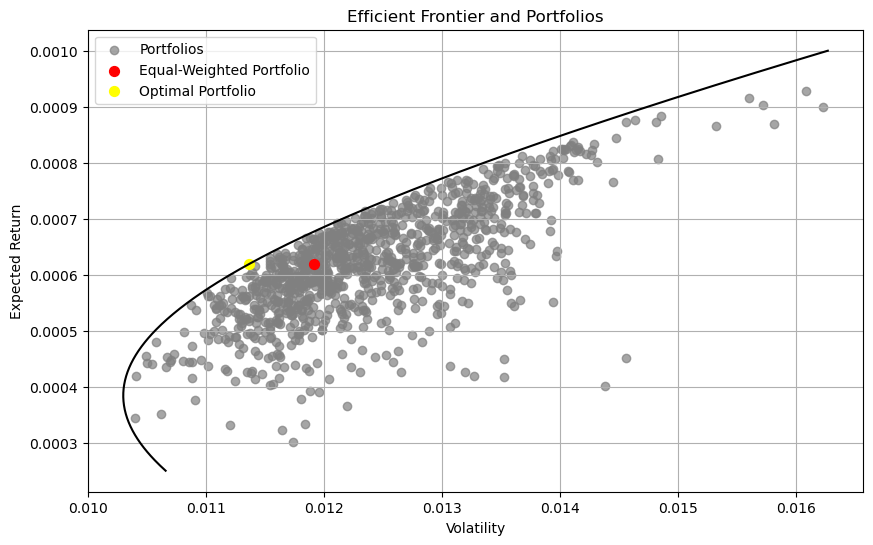

In [41]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='grey', alpha=0.7, label='Portfolios')
plt.plot(sigma_P_values, mu_P_values, color='black')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio')  
plt.scatter(risk_e_optimal, returns_e, color='yellow', s=50, label='Optimal Portfolio') 

# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()


To find the minimum variance portfolio we can use the following equation:

Returns: $ \mu_{P_{min}} = \frac{\pi_1}{2\pi_2} $

Variance: $ \sigma_{P_{min}}^2 = \pi_0 - \frac{\pi_1^2}{4\pi_2} $ 

In [42]:
# Get the MVP
min_returns = pi_1/(2*pi_2)
min_volat = np.sqrt(pi_0 - ((pi_1**2)/(4*pi_2)))

print(f"The MVP Returns are: {min_returns[0][0]}")
print(f"The MVP Volatility is: {min_volat[0][0]}")

The MVP Returns are: 0.0003841153108363164
The MVP Volatility is: 0.010295455594039311


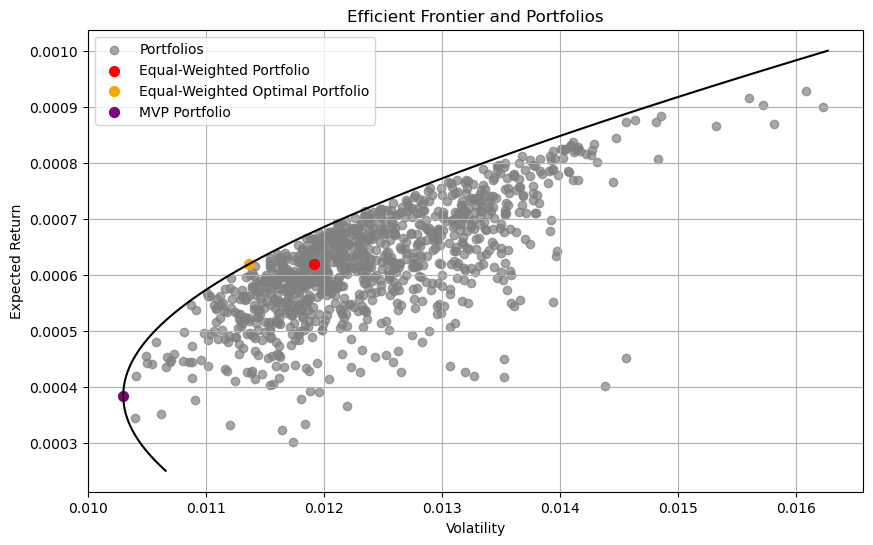

In [43]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.scatter(portfolios['Std Dev'], portfolios['Mean Return'], color='grey', alpha=0.7, label='Portfolios')
plt.plot(sigma_P_values, mu_P_values, color='black')
plt.scatter(risk_e, returns_e, color='red', s=50, label='Equal-Weighted Portfolio')  
plt.scatter(risk_e_optimal, returns_e, color='orange', s=50, label='Equal-Weighted Optimal Portfolio') 
plt.scatter(min_volat, min_returns, color='purple', s=50, label='MVP Portfolio') 

# Config
plt.title('Efficient Frontier and Portfolios')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Show
plt.grid(True)
plt.show()